# Figures 

## Libraries

In [1]:
import sys
sys.path.insert(0, 'src')

from powerlawdata.solver import silverstein_density, end_pts
from powerlawdata.datasets import load_cifar10, load_mnist, get_dataset

import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns 
import torch
from IPython.display import display, Latex

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



## Functions

power law population density generation

In [2]:
def gen_lambda(M, alpha):
    return torch.diag(torch.tensor([ float(k**(-alpha)) for k in range(1, M+1)], device = device))

fractional difference plotting

In [3]:
def frac_excess(eigs, bins: np.ndarray, alpha: float, q: float, Lc: float):


    hist, bin_edges = np.histogram(eigs, bins, density=True)
    bin_midpoints = (bin_edges[:-1] + bin_edges[1:]) / 2

    evals = bin_midpoints[::-1]
    num_density = silverstein_density(evals, alpha = alpha, q = q, Lc = Lc)
    rho_dict = {}
    for z, rho in zip(evals, num_density):
        rho_dict[z] = (q if q > 1 else 1)*abs(rho)
    zL, zR = end_pts(rho_dict)

    rho_excess_tuples = [(z, (hist[i]-abs(rho_dict[z]))/hist[i]) for i, z in enumerate(bin_midpoints) if zR >= z >= zL and rho_dict[z] is not None]

    return rho_excess_tuples

    


## Marcenko-Pastur

In [4]:
def rho_mp_an(q, z):
    lm ,lp = (1-np.sqrt(q))**2, (1+np.sqrt(q))**2
    return np.sqrt((lp-z)*(z-lm))/(2*np.pi)/q/z

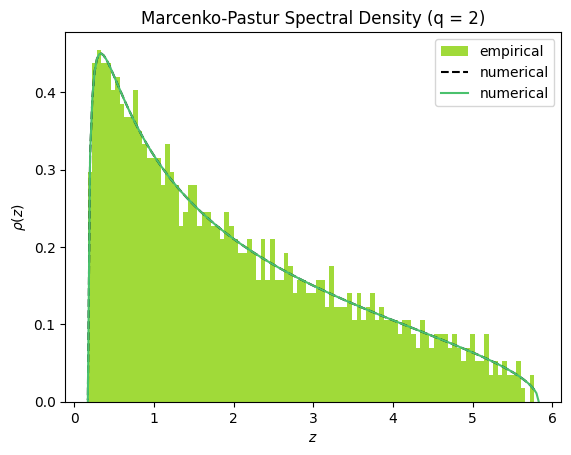

In [ ]:
#parameters
q = 2
alpha = 1e-5
lm ,lp = (1-np.sqrt(q))**2, (1+np.sqrt(q))**2
evals  = np.linspace(lp, lm, 200)

#numerical and analytical densities
num_density = silverstein_density(evals , alpha = alpha, q = q, Lc = 1-alpha)
an_density = [rho_mp_an(q, z) for z in evals]

#empirical
M = 2000
T = int(M/q)

dist = torch.distributions.multivariate_normal.MultivariateNormal(torch.zeros(M, device = device), gen_lambda(M, alpha))


PSI = dist.sample((T, ))
cov = PSI.T @ PSI /PSI.shape[0]
eigs = sorted(torch.linalg.eigvalsh(cov))[::-1]

sns.set_palette("viridis_r")


plt.hist(eigs, bins = np.linspace(lm, lp, 100), density = True, label = "empirical")
plt.plot(evals, [q*rho for rho in num_density], 'k--', label = "numerical")
plt.plot(evals, [q*rho for rho in an_density], label = "analytic")
plt.xlabel(r"$z$")
plt.ylabel(r"$\rho(z)$")
plt.title("Marcenko-Pastur Spectral Density (q = 2)")
plt.legend()
plt.savefig("figs/mp_q_2.png")
plt.show()


/var/folders/5z/pb__6h252xz54rgpylnspyw00000gn/T/ipykernel_11771/2393777015.py:14: RuntimeWarning: divide by zero encountered in scalar divide
  rho_excess_tuples = [(z, (hist[i]-abs(rho_dict[z]))/hist[i]) for i, z in enumerate(bin_midpoints) if zR >= z >= zL and rho_dict[z] is not None]


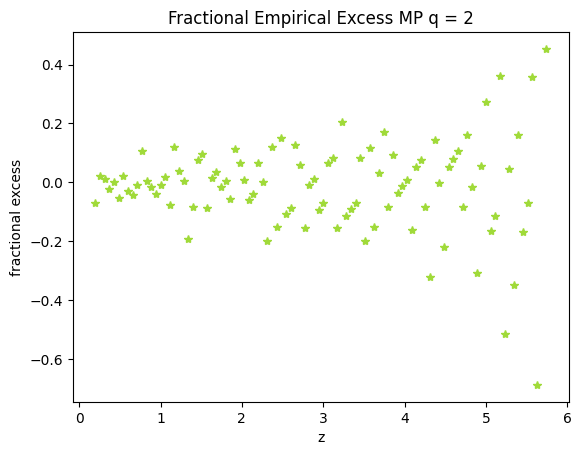

In [6]:
excess_tuples = frac_excess(eigs, bins = np.linspace(lm, lp, 100), alpha = alpha, q = q, Lc = 1-alpha)
excess_tuples = np.array(excess_tuples)
plt.plot(excess_tuples[:, 0], excess_tuples[:, 1], "*")
plt.xlabel("z")
plt.ylabel("fractional excess")
plt.title("Fractional Empirical Excess MP q = 2")
plt.savefig("figs/mp_frac_excess.png")
plt.show()

## Powerlaw 

In [7]:

#parameters
M = 1000
q = 2
alpha = 1.5
evals = np.logspace(1, -6, 250)

#numerical density
num_density = silverstein_density(evals , alpha = alpha, q = q, Lc = M**-alpha)
rho_dict = {}
for z, rho in zip(evals, num_density):
    rho_dict[z] = abs(rho)
zL, zR = end_pts(rho_dict)


#empirical
T = int(M/q)

dist = torch.distributions.multivariate_normal.MultivariateNormal(torch.zeros(M, device = device), gen_lambda(M, alpha))


PSI = dist.sample((T, ))
cov = PSI.T @ PSI /PSI.shape[0]
eigs = sorted(torch.linalg.eigvalsh(cov))[::-1]

/Users/aaronhillman/Desktop/ML/GitHub/Power-Law-Data/src/powerlawdata/solver.py:46: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  diff_re, _ = quad(int_re, np.log(Lc), 0)
/Users/aaronhillman/Desktop/ML/GitHub/Power-Law-Data/src/powerlawdata/solver.py:47: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  diff_im, _ = quad(int_im, np.log(Lc), 0)
/Users/aaronhillman/Desktop/ML/GitHub/Power-Law-Data/src/powerlawdata/solver.py:47: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  diff_im, _ = quad(int_im, np.log(Lc), 0)


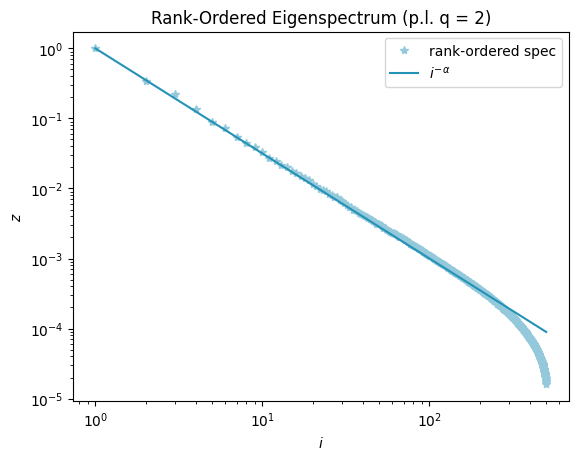

In [8]:
sns.set_palette("ocean_r")

max_idx = len(eigs) if q < 1 else len(eigs)//q
ranked_eigs = sorted(eigs)[::-1][:max_idx]
idxs= np.arange(1, 1+len(ranked_eigs))

plt.loglog(idxs, ranked_eigs, "*", label="rank-ordered spec")
plt.loglog(idxs, [i**(-alpha) for i in idxs], label = r"$i^{-\alpha}$")
plt.xlabel(r"$i$")
plt.ylabel(r"$z$")
plt.title("Rank-Ordered Eigenspectrum (p.l. q = 2)")
plt.legend()
plt.savefig("figs/pl_rank_ordered_q_2.png")
plt.show()

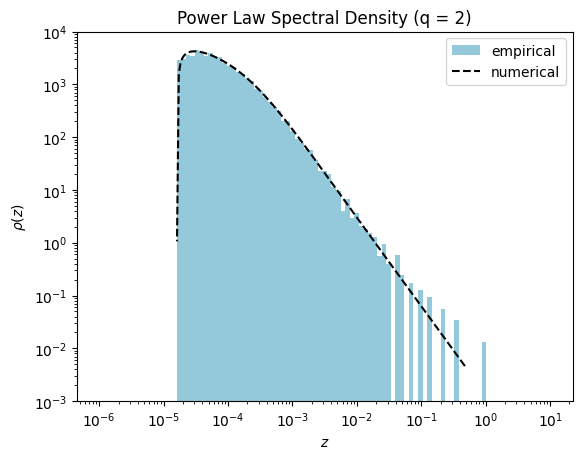

In [9]:
sns.set_palette("ocean_r")


plt.hist(eigs, np.logspace(-6, 1, 100), density = True, label = "empirical")
plt.plot([z for z in rho_dict.keys() if rho_dict[z] is not None and zR >= z >= zL], [q*rho_dict[z] for z in rho_dict.keys() if rho_dict[z] is not None and zR >= z >= zL], 'k--', label = "numerical")
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-3, 1e4)
plt.xlabel(r"$z$")
plt.ylabel(r"$\rho(z)$")
plt.title("Power Law Spectral Density (q = 2)")
plt.legend()
plt.savefig("figs/pl_spec_density_q_2.png")
plt.show()

/Users/aaronhillman/Desktop/ML/GitHub/Power-Law-Data/src/powerlawdata/solver.py:47: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  diff_im, _ = quad(int_im, np.log(Lc), 0)
/Users/aaronhillman/Desktop/ML/GitHub/Power-Law-Data/src/powerlawdata/solver.py:47: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  diff_im, _ = quad(int_im, np.log(Lc), 0)
/var/folders/5z/pb__6h252xz54rgpylnspyw00000gn/T/ipykernel_11771/2393777015.py:14: RuntimeWarning: divide by zero encountered in scalar divide
  rho_excess_tuples = [(z, (hist[i]-abs(rho_dict[z]))/hist[i]) for i, z in enumerate(bin_midpoints) if zR >= z >= zL and rho_dict[z] is not None]


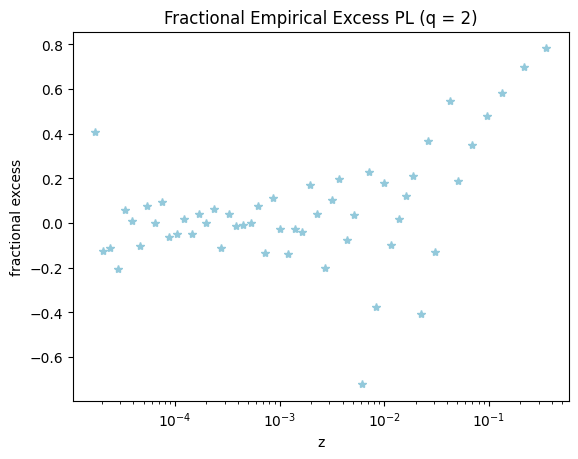

In [11]:
excess_tuples = frac_excess(eigs, np.logspace(-6, 1, 100), alpha = alpha, q = q, Lc = M**-alpha)
excess_tuples = np.array(excess_tuples)
plt.plot(excess_tuples[:, 0], excess_tuples[:, 1], "*")
plt.xscale('log')
plt.xlabel("z")
plt.ylabel("fractional excess")
plt.title("Fractional Empirical Excess PL (q = 2)")
plt.savefig("figs/pl_frac_excess_q_2.png")
plt.show()

### Near Equiparameterized

In [12]:
alpha = 1.7
q = .99
dist = torch.distributions.multivariate_normal.MultivariateNormal(torch.zeros(M, device = device), gen_lambda(M, alpha))
T = int(M/q)
PSI = dist.sample((T, ))
cov = PSI.T @ PSI /T
eigs = sorted(torch.linalg.eigvalsh(cov))[::-1]


evals = np.logspace(-12, 0.5, 600)[::-1]
Lc = M**-alpha
c = 1/alpha*1/(1-np.power(Lc, 1/alpha))



In [13]:
#numerical and analytical densities
num_density = silverstein_density(evals , alpha = alpha, q = q, Lc = M**-alpha)
rho_dict = {}
for z, rho in zip(evals, num_density):
    rho_dict[z] = abs(rho)
zL, zR = end_pts(rho_dict)


/Users/aaronhillman/Desktop/ML/GitHub/Power-Law-Data/src/powerlawdata/solver.py:46: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  diff_re, _ = quad(int_re, np.log(Lc), 0)
/Users/aaronhillman/Desktop/ML/GitHub/Power-Law-Data/src/powerlawdata/solver.py:46: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  diff_re, _ = quad(int_re, np.log(Lc), 0)
/Users/aaronhillman/Desktop/ML/GitHub/Power-Law-Data/src/powerlawdata/solver.py:46: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably 

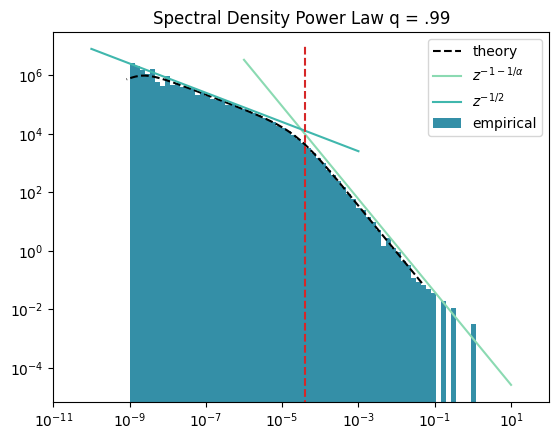

In [ ]:
sns.set_palette("mako_r")


plt.loglog([z for z in rho_dict.keys() if zR >= z >= zL and rho_dict[z] is not None], [rho_dict[z] for z in rho_dict.keys() if zR >= z >= zL and rho_dict[z] is not None], "k--", label= "theory")
plt.loglog([z for z in np.logspace(-6, 1, 20)], [1e-3*z**-(1+1/alpha) for z in np.logspace(-6, 1, 20)], label=r"$z^{-1-1/\alpha}$")
plt.loglog([z for z in np.logspace(-10, -3, 20)], [8e1*z**-(.5) for z in np.logspace(-10, -3, 20)], label=r"$z^{-1/2}$")
plt.vlines(4e-5, 1e-9, 1e7, colors="tab:red", linestyles="dashed")
plt.hist(eigs, bins =np.logspace(-12, 1, 100), density=True, label="empirical")
plt.xlim(1e-11, 1e2)
plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"$z$")
plt.ylabel(r"$\rho(z)$")
plt.title(r"Spectral Density PL ($q = .99$, $\alpha = 1.7$)")
plt.legend()
plt.savefig("figs/pl_spec_density_q_99.png")
plt.show()

/Users/aaronhillman/Desktop/ML/GitHub/Power-Law-Data/src/powerlawdata/solver.py:46: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  diff_re, _ = quad(int_re, np.log(Lc), 0)
/Users/aaronhillman/Desktop/ML/GitHub/Power-Law-Data/src/powerlawdata/solver.py:47: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  diff_im, _ = quad(int_im, np.log(Lc), 0)
/var/folders/5z/pb__6h252xz54rgpylnspyw00000gn/T/ipykernel_11771/2393777015.py:14: RuntimeWarning: divide by zero encountered in scalar divide
  rho_excess_tuples = [(z, (hist[i]-abs(rho_dict[z]))/hist[i]) for i, z i

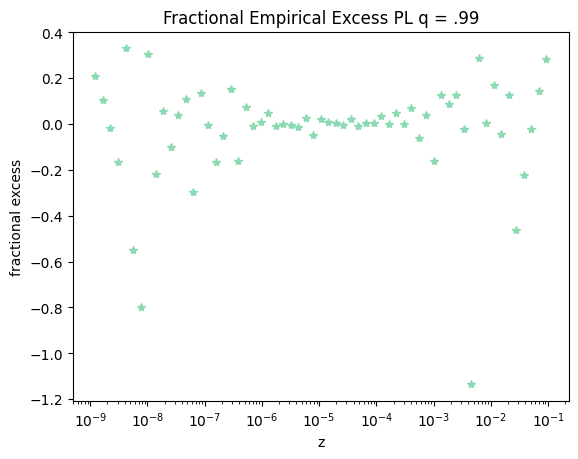

In [ ]:
excess_tuples = frac_excess(eigs, bins =np.logspace(-12, 1, 100), alpha = alpha, q = q, Lc = M**-alpha)
excess_tuples = np.array(excess_tuples)
plt.plot(excess_tuples[:, 0], excess_tuples[:, 1], "*")
plt.xscale('log')
plt.xlabel("z")
plt.ylabel("fractional excess")
plt.title("Fractional Empirical Excess PL (q = .99)")
plt.savefig("figs/pl_frac_excess_q_99.png")
plt.show()

## Natural Data

### CIFAR10

In [4]:
# example quick smoke test
X_CIFAR = load_cifar10({"data_dir": "data", "split": "train"})
print("CIFAR10 shape:", X_CIFAR.shape)

CIFAR10 shape: (50000, 3072)


In [5]:
Xtr = torch.tensor(X_CIFAR).to(dtype=torch.float64, device = device)
Xcent = Xtr-Xtr.mean(axis = 0)
C = Xcent.T @ Xcent/Xcent.shape[0]
eigs_cifar = sorted(torch.linalg.eigvalsh(C))[::-1]

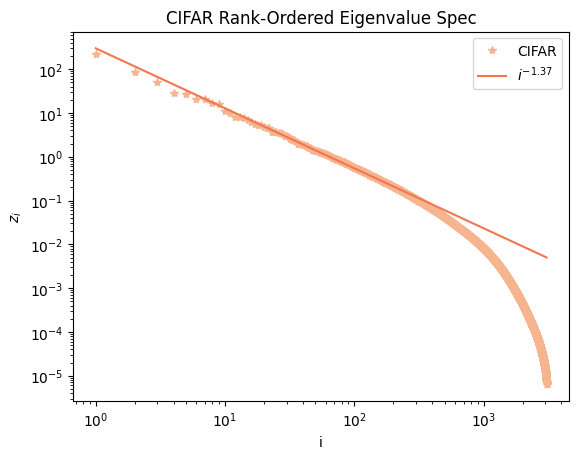

In [ ]:
sns.set_palette("rocket_r")


plt.loglog(range(1, len(eigs_cifar)+1), eigs_cifar, "*", label="CIFAR")
plt.loglog(range(1, len(eigs_cifar)+1), [3e2*l**-1.37 for l in range(1, len(eigs_cifar)+1)], label=r"$i^{-1.37}$")
plt.xlabel(r"$i$")
plt.ylabel(r"$z$")
plt.title("CIFAR Rank-Ordered Eigenvalue Spec")
plt.legend()
plt.savefig("figs/cifar_rank_ordered.png")
plt.show()


In [8]:
evals = np.logspace(-.1,-6, 400)
q = 32*32*3/50000
alpha = 1.37
M = 32*32*3
Lc = 5e-1*M**-alpha
c = 1/alpha*1/(1-np.power(Lc, 1/alpha))

num_density = silverstein_density(evals , alpha = alpha, q = q, Lc = Lc)
rho_dict = {}
for z, rho in zip(evals, num_density):
    rho_dict[z] = abs(rho)
zL, zR = end_pts(rho_dict)

/Users/aaronhillman/Desktop/ML/GitHub/Power-Law-Data/src/powerlawdata/solver.py:47: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  diff_im, _ = quad(int_im, np.log(Lc), 0)
/Users/aaronhillman/Desktop/ML/GitHub/Power-Law-Data/src/powerlawdata/solver.py:46: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  diff_re, _ = quad(int_re, np.log(Lc), 0)


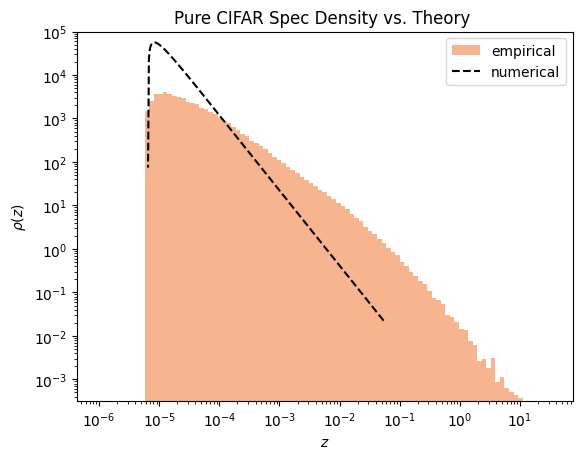

In [9]:
plt.hist(eigs_cifar, np.logspace(-6, 1.5, 100), density = True, label = "empirical")
plt.plot([z for z in rho_dict.keys() if rho_dict[z] is not None and zR >= z >= zL], [rho_dict[z] for z in rho_dict.keys() if rho_dict[z] is not None and zR >= z >= zL], 'k--', label = "numerical")
plt.xscale('log')
plt.yscale('log')
plt.ylim(10**-3.5, 10**5)
plt.xlabel(r"$z$")
plt.ylabel(r"$\rho(z)$")
plt.title("Pure CIFAR Spec Density vs. Theory ")
plt.legend()
plt.savefig("figs/cifar_spec_density.png")
plt.show()

In [10]:
-np.trapezoid([rho_dict[z] for z in rho_dict.keys() if rho_dict[z] is not None and zR >= z >= zL], [z for z in rho_dict.keys() if rho_dict[z] is not None and zR >= z >= zL])

np.float64(0.9993036060164197)

#### ReLU Mapping

In [11]:
NReLU = 10000
u = torch.randn((NReLU, 32*32*3), dtype = torch.float64, device = device)
Xtr.to(dtype=torch.float64, device = device)
XReLU = torch.nn.ReLU()(Xtr @ u.T/NReLU)
Xcent = XReLU-XReLU.mean(axis = 0)
CRel = Xcent.T @ Xcent/Xcent.shape[0]
eigs_relu = sorted(torch.linalg.eigvalsh(CRel))[::-1]

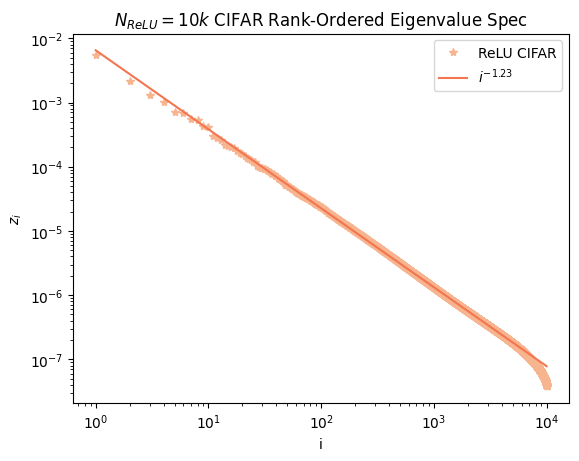

In [ ]:
sns.set_palette("rocket_r")

plt.loglog(range(1, len(eigs_relu)+1), eigs_relu, "*", label="ReLU CIFAR")
plt.loglog(range(1, len(eigs_relu)+1), [6.5e-3*l**-1.23 for l in range(1, len(eigs_relu)+1)], label=r"$i^{-1.23}$")
plt.xlabel(r"i")
plt.ylabel(r"$z$")
plt.title(r"$N_{ReLU} = 10k$ CIFAR Rank-Ordered Eigenvalue Spec")
plt.legend()
plt.savefig("figs/cifar_relu_rank_ordered.png")
plt.show()

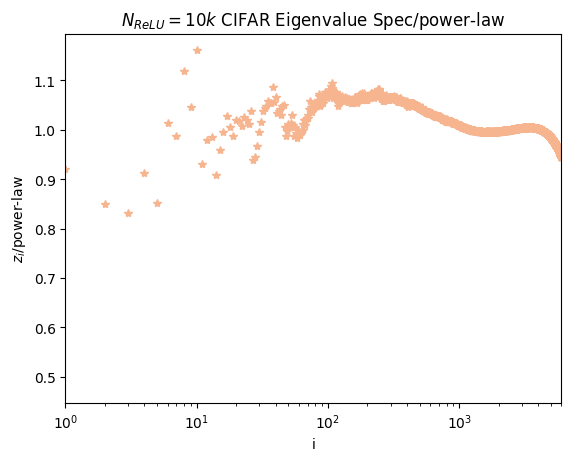

In [ ]:
sns.set_palette("rocket_r")

plt.plot(range(1, len(eigs_relu)+1), [eigs_relu[l-1]/(6e-3*l**-1.22) for l in range(1, len(eigs_relu)+1)], "*")
plt.xscale('log')
plt.xlabel(r"i")
plt.xlim(1, 6e3)
plt.ylabel(r"$z/$power-law")
plt.title(r"$N_{ReLU} = 10k$ CIFAR Eigenvalue Spec/power-law")
plt.savefig("figs/cifar_relu_power_frac.png")
plt.show()

In [46]:
T = 5e4
M = 10000
q = M/T
eps = 1e-9
alpha = 1.23
Lc = 6.45e-3*M**-alpha
c = 1/alpha*1/(1-np.power(Lc, 1/alpha))

evals = np.logspace(-7.5, -3, 500)[::-1]
num_density = silverstein_density(evals , alpha = alpha, q = q, Lc = Lc)
rho_dict = {}
for z, rho in zip(evals, num_density):
    rho_dict[z] = abs(rho)
zL, zR = end_pts(rho_dict)

In [38]:
-np.trapezoid([rho_dict[z] for z in rho_dict.keys() if rho_dict[z] is not None and zR >= z >= zL], [z for z in rho_dict.keys() if rho_dict[z] is not None and zR >= z >= zL])

np.float64(0.9931839705601792)

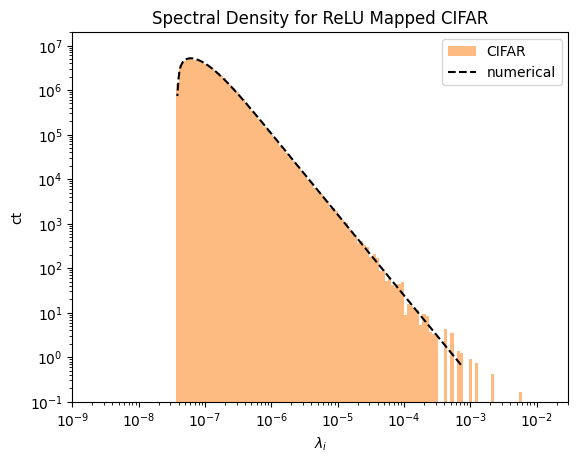

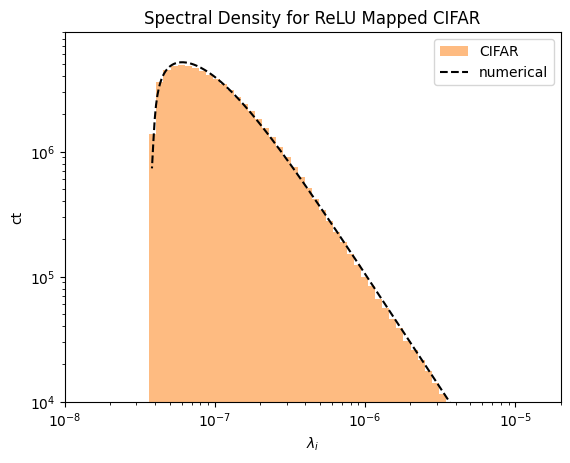

In [ ]:
sns.set_palette("magma_r")

plt.hist(eigs_relu, bins=np.logspace(-8,-1, 150), density = True, label="CIFAR")
plt.plot([z for z in rho_dict.keys() if rho_dict[z] is not None and zR >= z >= zL], [rho_dict[z] for z in rho_dict.keys() if rho_dict[z] is not None and zR >= z >= zL], 'k--', label = "numerical")
plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"$z$")
plt.ylabel(r"$\rho(z)$")
plt.title(f"ReLU CIFAR Spectral Density")
plt.xlim(1e-9, 3e-2)
plt.ylim(1e-1, 2e7)
plt.legend()
plt.savefig("figs/cifar_relu_spec_density.png")
plt.show()

sns.set_palette("magma_r")

plt.hist(eigs_relu, bins=np.logspace(-8,-1, 150), density = True, label="CIFAR")
plt.plot([z for z in rho_dict.keys() if rho_dict[z] is not None and zR >= z >= zL], [rho_dict[z] for z in rho_dict.keys() if rho_dict[z] is not None and zR >= z >= zL], 'k--', label = "numerical")
plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"$z$")
plt.ylabel(r"$\rho(z)$")
plt.title(f"ReLU CIFAR Spectral Density")
plt.xlim(1e-8, 2e-5)
plt.ylim(1e4, 9e6)
plt.legend()
plt.savefig("figs/cifar_relu_spec_density_zoom.png")
plt.show()

/var/folders/5z/pb__6h252xz54rgpylnspyw00000gn/T/ipykernel_13118/2393777015.py:14: RuntimeWarning: divide by zero encountered in scalar divide
  rho_excess_tuples = [(z, (hist[i]-abs(rho_dict[z]))/hist[i]) for i, z in enumerate(bin_midpoints) if zR >= z >= zL and rho_dict[z] is not None]


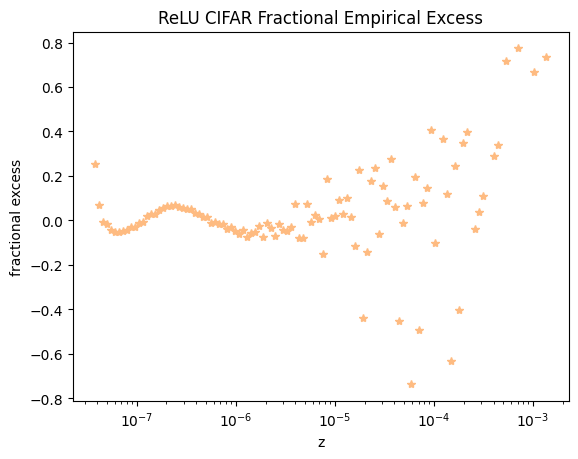

In [49]:
excess_tuples = frac_excess(eigs_relu, bins=np.logspace(-8,-2, 150), alpha = alpha, q = q, Lc = Lc)
excess_tuples = np.array(excess_tuples)
plt.plot(excess_tuples[:, 0], excess_tuples[:, 1], "*")
plt.xscale('log')
plt.xlabel("z")
plt.ylabel("fractional excess")
plt.title("ReLU CIFAR Fractional Empirical Excess")
plt.savefig("figs/cifar_relu_frac_excess.png")
plt.show()

### MNIST

In [50]:
X_MNIST = load_mnist({"data_dir": "data", "split": "train"})

In [51]:
Xcent = X_MNIST-X_MNIST.mean(axis = 0)
Xcent = torch.tensor(Xcent).to(dtype = torch.float64, device = device)/3
C = Xcent.T @ Xcent/Xcent.shape[0]
eigs_mnist = sorted(torch.linalg.eigvalsh(C))[::-1]

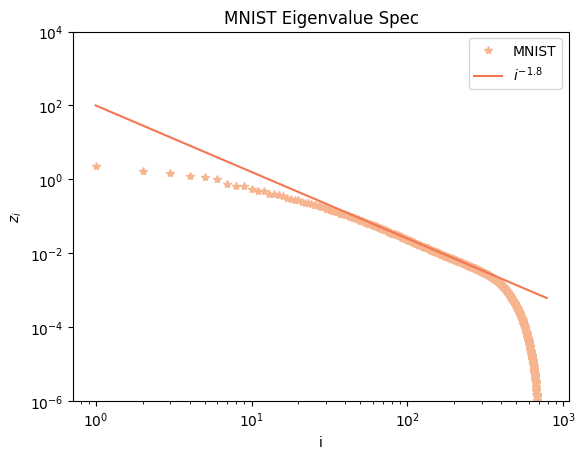

In [ ]:
sns.set_palette("rocket_r")

k_data = [i for i in range(1, len(eigs_mnist)+1)]
p = 2.5
plt.loglog(range(1, len(eigs_mnist)+1), [eig.cpu() for eig in eigs_mnist], "*", label="MNIST")
plt.loglog(k_data, [1e2/k**1.8 for k in k_data], label=r"$i^{-1.8}$")
plt.xlabel(r"i")
plt.ylabel(r"$z$")
plt.ylim(1e-8, 1e3)
plt.title("MNIST Eigenvalue Spec")
plt.legend()
plt.savefig("figs/mnist_rank_ordered.png")
plt.show()

In [65]:
q = 1.01
eps = 1e-9
alpha = 1.75
Lc = 1e-3
c = 1/alpha*1/(1-np.pow(Lc, 1/alpha))

evals = np.logspace(-8, .9, 500)[::-1]
num_density = silverstein_density(evals , alpha = alpha, q = q, Lc = Lc)
rho_dict = {}
for z, rho in zip(evals, num_density):
    rho_dict[z] = abs(rho)
zL, zR = end_pts(rho_dict)

/Users/aaronhillman/Desktop/ML/GitHub/Power-Law-Data/src/powerlawdata/solver.py:46: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  diff_re, _ = quad(int_re, np.log(Lc), 0)


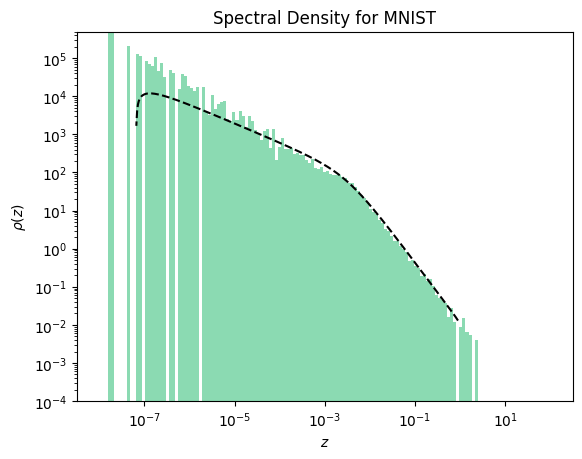

In [ ]:
sns.set_palette("mako_r")


plt.hist([eig.cpu() for eig in eigs_mnist], bins=np.logspace(-8,2, 150), density = True, label="empirica")
plt.plot([z for z in rho_dict.keys() if rho_dict[z] is not None and zR >= z >= zL], [q*rho_dict[z] for z in rho_dict.keys() if rho_dict[z] is not None and zR >= z >= zL], 'k--', label = "numerical")
#plt.loglog([eig.cpu() for eig in eigs_mnist if eig > 1e-3], [1e-1*eig.cpu()**-(1+1/1.8) for eig in eigs_mnist if eig > 1e-3])
#plt.loglog([eig.cpu() for eig in eigs_mnist if eig > 1e-7], [2*eig.cpu()**-(.6)/2 for eig in eigs_mnist if eig > 1e-7])
plt.ylim(1e-4, 5e5)
plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"$z$")
plt.ylabel(r"$\rho(z)$")
plt.title(f"Spectral Density for MNIST")
plt.legend()
plt.savefig("figs/mnist_spec_density.png")
plt.show()

/Users/aaronhillman/Desktop/ML/GitHub/Power-Law-Data/src/powerlawdata/solver.py:47: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  diff_im, _ = quad(int_im, np.log(Lc), 0)
/var/folders/5z/pb__6h252xz54rgpylnspyw00000gn/T/ipykernel_13118/2393777015.py:14: RuntimeWarning: divide by zero encountered in scalar divide
  rho_excess_tuples = [(z, (hist[i]-abs(rho_dict[z]))/hist[i]) for i, z in enumerate(bin_midpoints) if zR >= z >= zL and rho_dict[z] is not None]
/var/folders/5z/pb__6h252xz54rgpylnspyw00000gn/T/ipykernel_13118/1456930284.py:5: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(1e-5, 0)


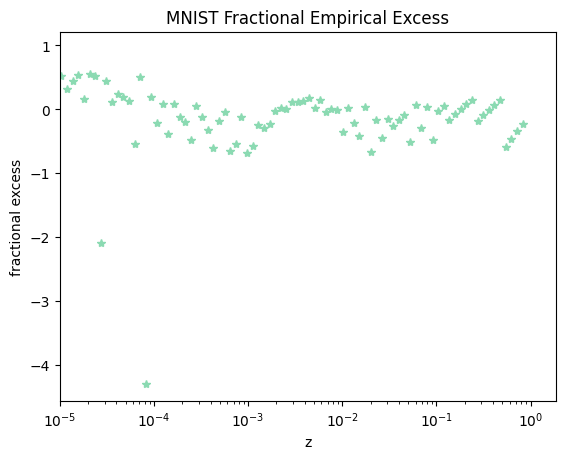

In [57]:
excess_tuples = frac_excess(eigs_mnist, bins=np.logspace(-8,0.9, 150), alpha = alpha, q = q, Lc = Lc)
excess_tuples = np.array(excess_tuples)
plt.plot(excess_tuples[:, 0], excess_tuples[:, 1], "*")
plt.xscale('log')
plt.xlim(1e-5, 0)
plt.xlabel("z")
plt.ylabel("fractional excess")
plt.title("MNIST Fractional Empirical Excess")
plt.savefig("figs/mnist_frac_excess.png")
plt.show()

##### ReLU

In [58]:
NReLU = 10000
u = torch.randn((NReLU, 28*28)).to(dtype = torch.float64, device = device)
XReLU = torch.nn.ReLU()(torch.tensor(X_MNIST).to(dtype = torch.float64, device = device) @ u.T/np.sqrt(NReLU))
Xcent = XReLU-XReLU.mean(axis = 0)
CRel = Xcent.T @ Xcent/Xcent.shape[0]
eigs_relu = sorted(torch.linalg.eigvalsh(CRel))[::-1]

In [67]:
q = 1.03
alpha = 1.5
Lc = 6.75e1*1e4**-alpha
c = 1/alpha*1/(1-np.power(Lc, 1/alpha))

evals = np.logspace(-9, 1, 550)[::-1]
num_density = silverstein_density(evals , alpha = alpha, q = q, Lc = Lc)
rho_dict = {}
for z, rho in zip(evals, num_density):
    rho_dict[z] = abs(rho)
zL, zR = end_pts(rho_dict)

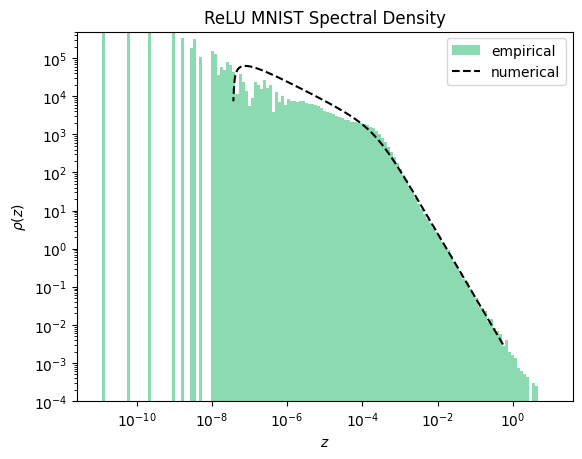

In [68]:
sns.set_palette("mako_r")

plt.hist([eig.cpu() for eig in eigs_relu], bins=np.logspace(-11,1, 150), density = True, label="empirical")
plt.plot([z for z in rho_dict.keys() if rho_dict[z] is not None and zR >= z >= zL], [q*rho_dict[z] for z in rho_dict.keys() if rho_dict[z] is not None and zR >= z >= zL], 'k--', label = "numerical")
#plt.loglog([eig.cpu() for eig in eigs_mnist if eig > 1e-3], [1e-1*eig.cpu()**-(1+1/1.8) for eig in eigs_mnist if eig > 1e-3])
#plt.loglog([eig.cpu() for eig in eigs_mnist if eig > 1e-7], [2*eig.cpu()**-(.6)/2 for eig in eigs_mnist if eig > 1e-7])
plt.ylim(1e-4, 5e5)
plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"$z$")
plt.ylabel(r"$\rho(z)$")
plt.title(f"ReLU MNIST Spectral Density")
plt.legend()
plt.savefig("figs/mnist_relu_spec_density.png")
plt.show()

/Users/aaronhillman/Desktop/ML/GitHub/Power-Law-Data/src/powerlawdata/solver.py:46: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  diff_re, _ = quad(int_re, np.log(Lc), 0)


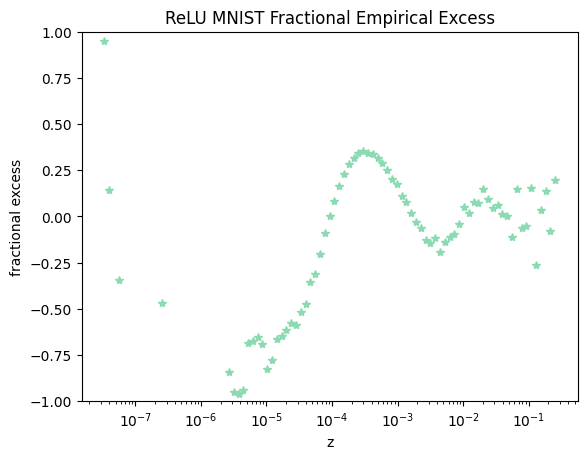

In [63]:
excess_tuples = frac_excess(eigs_relu, bins=np.logspace(-10,0.9, 150), alpha = alpha, q = q, Lc = Lc)
excess_tuples = np.array(excess_tuples)
plt.plot(excess_tuples[:, 0], excess_tuples[:, 1], "*")
plt.xscale('log')
plt.ylim(-1, 1)
plt.xlabel("z")
plt.ylabel("fractional excess")
plt.title("ReLU MNIST Fractional Empirical Excess")
plt.savefig("figs/mnist_relu_frac_excess.png")
plt.show()

### Wikitext

In [69]:
import os
from tokenizers import ByteLevelBPETokenizer

In [70]:
wiki_data = get_dataset("wikitext", {"data_dir": "data", "split": "train[:5%]"})

with open("data/wiki-text_sample.txt", "w") as f:
    for datum in wiki_data:
        f.write(datum['text']+'\n')

In [71]:
if not os.path.exists("tokenizers/custom-tokenizer-8k-vocab.json") or not os.path.exists("tokenizers/custom-tokenizer-8k-merges.txt"):
    tokenizer = ByteLevelBPETokenizer()
    tokenizer.train(files="data/wiki-text_sample.txt", vocab_size=8000, min_frequency=2)
    tokenizer.save_model("tokenizers", "custom-tokenizer-8k")

tokenizer = ByteLevelBPETokenizer(
    "tokenizers/custom-tokenizer-8k-vocab.json",
    "tokenizers/custom-tokenizer-8k-merges.txt"
)

#### First the 8k Vocab w/ 8k Embedding

In [72]:
if os.path.exists("data/wiki_8k_8k_100k_eigs.npy"):
    eigs_8k_8k = np.load("data/wiki_8k_8k_100k_eigs.npy")
else:

    tokenizer = ByteLevelBPETokenizer(
        "tokenizers/custom-tokenizer-8k-vocab.json",
        "tokenizers/custom-tokenizer-8k-merges.txt"
    )

    Xstream = torch.cat([torch.tensor(tokenizer.encode(x['text']).ids, dtype=torch.long) for x in wiki_data])

    unique_tokens = len(set([x.item() for x in Xstream]))
    n_embed = 8000

    Xtr = torch.nn.Embedding(8000, n_embed)(Xstream[:100000]).to(dtype = torch.float64)
    Xtr = Xtr-Xtr.mean(0)
    Xtr = torch.nn.ReLU()(Xtr)


    eigs = torch.linalg.eigvalsh(Xtr.T @ Xtr/Xtr.shape[0]/100)

    eigs = np.array(sorted([eig.detach().item() for eig in eigs ])[::-1][:unique_tokens])

    eigs_8k_8k = eigs

    np.save("data/wiki_8k_8k_100k_eigs.npy",eigs_8k_8k)

In [73]:
evals= np.logspace(-6, 0, 600)[::-1]
q = 1.14
alpha = 1
Lc = 4.8e-4
c = 1/alpha*1/(1-np.power(Lc, 1/alpha))

num_density = silverstein_density(evals , alpha = alpha, q = q, Lc = Lc)
rho_dict = {}
for z, rho in zip(evals, num_density):
    rho_dict[z] = abs(rho)
zL, zR = end_pts(rho_dict)

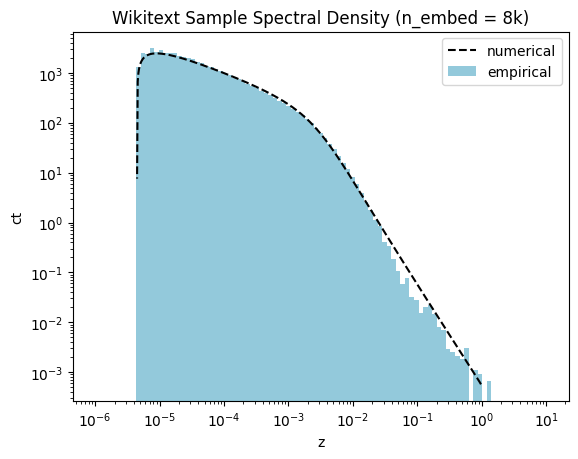

In [ ]:
sns.set_palette("ocean_r")

plt.plot([z for z in rho_dict.keys() if rho_dict[z] is not None and zR >= z >= zL], [q*rho_dict[z] for z in rho_dict.keys() if rho_dict[z] is not None and zR >= z >= zL], 'k--', label = "numerical")
plt.hist(eigs_8k_8k, bins = np.logspace(-6, 1, 100), density = True, label="empirical")
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r"$z$")
plt.ylabel(r"$\rho(z)$")
plt.title("Wikitext Sample Spectral Density (n_embed = 8k)")
plt.legend()
plt.savefig("figs/wiki_emb_8k_spec_density.png")
plt.show()

/Users/aaronhillman/Desktop/ML/GitHub/Power-Law-Data/src/powerlawdata/solver.py:47: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  diff_im, _ = quad(int_im, np.log(Lc), 0)
/Users/aaronhillman/Desktop/ML/GitHub/Power-Law-Data/src/powerlawdata/solver.py:47: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  diff_im, _ = quad(int_im, np.log(Lc), 0)
/var/folders/5z/pb__6h252xz54rgpylnspyw00000gn/T/ipykernel_13118/2393777015.py:14: RuntimeWarning: divide by zero encountered in scalar divide
  rho_excess_tuples = [(z, (hist[i]-abs(rho_dict[z]))/hist[i]) for i, z in enumerate(bin_midpoints) if zR >= z >= zL and rho_dict[z] is not None]


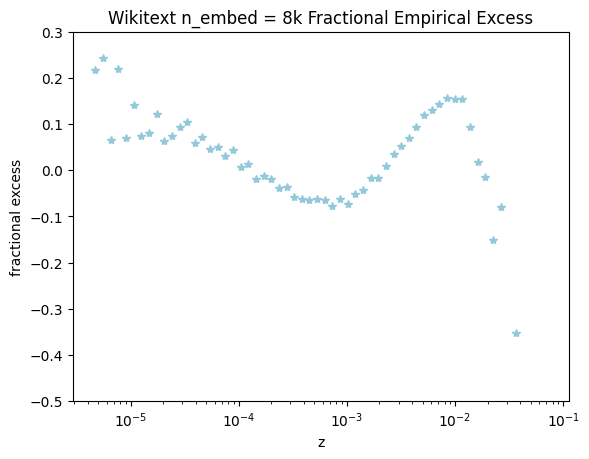

In [76]:
excess_tuples = frac_excess(eigs_8k_8k, bins=np.logspace(-6, 1, 100), alpha = alpha, q = q, Lc = Lc)
excess_tuples = np.array(excess_tuples)
plt.plot(excess_tuples[:, 0], excess_tuples[:, 1], "*")
plt.xscale('log')
plt.ylim(-.5, .3)
plt.xlabel("z")
plt.ylabel("fractional excess")
plt.title("Wikitext n_embed = 8k Fractional Empirical Excess")
plt.savefig("figs/wiki_8k_frac_excess.png")
plt.show()

#### First the 8k Vocab w/ 4k Embedding

In [77]:
if os.path.exists("data/wiki_8k_4k_100k_eigs.npy"):
    eigs_8k_4k = np.load("data/wiki_8k_4k_100k_eigs.npy")
else:

    tokenizer = ByteLevelBPETokenizer(
        "tokenizers/custom-tokenizer-8k-vocab.json",
        "tokenizers/custom-tokenizer-8k-merges.txt"
    )

    Xstream = torch.cat([torch.tensor(tokenizer.encode(x['text']).ids, dtype=torch.long) for x in wiki_data])

    unique_tokens = len(set([x.item() for x in Xstream]))
    n_embed = 4000

    Xtr = torch.nn.Embedding(8000, n_embed)(Xstream[:100000]).to(dtype = torch.float64)
    Xtr = Xtr-Xtr.mean(0)
    Xtr = torch.nn.ReLU()(Xtr)

    eigs = torch.linalg.eigvalsh(Xtr.T @ Xtr/Xtr.shape[0]/100)

    eigs = np.array(sorted([eig.detach().item() for eig in eigs ])[::-1][:unique_tokens])

    eigs_8k_4k = eigs

    np.save("data/wiki_8k_4k_100k_eigs.npy", eigs_8k_4k)

In [78]:
evals=  np.logspace(-5, 0, 600)[::-1]
q = .58
alpha = .98
Lc = 5.7e-4
c = 1/alpha*1/(1-np.power(Lc, 1/alpha))


num_density = silverstein_density(evals , alpha = alpha, q = q, Lc = Lc)
rho_dict = {}
for z, rho in zip(evals, num_density):
    rho_dict[z] = abs(rho)
zL, zR = end_pts(rho_dict)

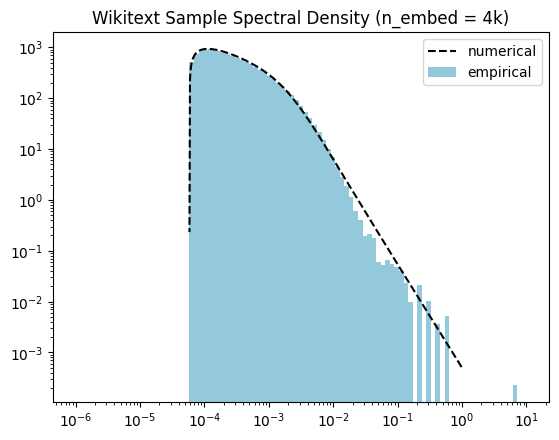

In [ ]:
sns.set_palette("ocean_r")

plt.plot([z for z in rho_dict.keys() if rho_dict[z] is not None and zR >= z >= zL], [rho_dict[z] for z in rho_dict.keys() if rho_dict[z] is not None and zR >= z >= zL], 'k--', label = "numerical")
plt.hist(eigs_8k_4k, bins = np.logspace(-6, 1, 100), density = True, label="empirical")
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r"$z$")
plt.ylabel(r"$\rho(z)$")
plt.title("Wikitext Sample Spectral Density (n_embed = 4k)")
plt.legend()
plt.savefig("figs/wiki_emb_4k_spec_density.png")
plt.show()

/var/folders/5z/pb__6h252xz54rgpylnspyw00000gn/T/ipykernel_13118/2393777015.py:14: RuntimeWarning: divide by zero encountered in scalar divide
  rho_excess_tuples = [(z, (hist[i]-abs(rho_dict[z]))/hist[i]) for i, z in enumerate(bin_midpoints) if zR >= z >= zL and rho_dict[z] is not None]


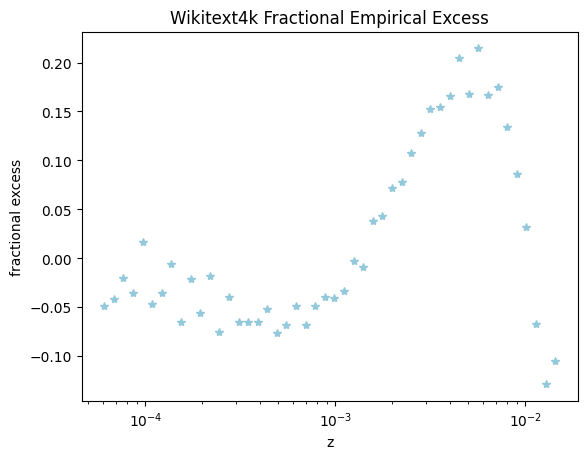

In [80]:
excess_tuples = frac_excess(eigs_8k_4k, bins=np.logspace(-5, 0, 100), alpha = alpha, q = q, Lc = Lc)
excess_tuples = np.array(excess_tuples)
plt.plot(excess_tuples[:, 0], excess_tuples[:, 1], "*")
plt.xscale('log')
#plt.ylim(-.5, .3)
plt.xlabel("z")
plt.ylabel("fractional excess")
plt.title("Wikitext4k Fractional Empirical Excess")
plt.savefig("figs/wiki_4k_frac_excess.png")
plt.show()